# Tabular Cleaning Toolbox Demo
Bags (Tas) Product Analysis with Web Scraping (Tokopedia)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from statsmodels.miscmodels.ordinal_model import OrderedModel

df = pd.read_csv('scrapTokopedia_tas.csv')
df = df.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
df

,productName,price,priceOld,rating,amountSold
0,TAS SLEMPANG HP WANITA ORI CHIBAO KANVAS 3Ruang,Rp67.000,NaN,4.9,30+ terjual
1,Frisco Canvas plain bag strap / tali tas selem...,Rp105.000,NaN,5.0,10 terjual
2,Totebag Transparan | Tas Mika PVC Transparan |...,Rp8.910,NaN,4.9,10rb+ terjual
3,Tas Ransel Semi Carrier Grunnies 30 Liter Arei...,Rp549.000,NaN,4.9,30+ terjual
4,Tas lurik anyaman Tas keranjang anyaman Tas be...,Rp11.499,NaN,4.9,10rb+ terjual
...,...,...,...,...,...
1195,TAS SELEMPANG WANITA IMPORT CHIBAO 19941#,Rp98.000,NaN,4.9,50+ terjual
1196,Berrybenka - Tas Selempang Wanita Sofia Rulla ...,Rp142.000,Rp329.000,4.9,250+ terjual
1197,WESTBRONCO [PUFFER KOORA BAG] Tas Bahu Wanita ...,Rp259.999,Rp577.776,4.9,250+ terjual
1198,MOCO Fashion Sling Bag Wanita Tas Selempang Sa...,Rp106.999,Rp289.000,5.0,30+ terjual


In [2]:
import nluztoolbox

print(f"✅ Successfully imported toolbox package!")
print(f"📦 Using toolbox version: {nluztoolbox.__version__}")

cleaner = nluztoolbox.TabularCleaning(df)

✅ Successfully imported toolbox package!
📦 Using toolbox version: 0.3.1


In [3]:
print(df.isnull().sum())
print(df.dtypes)

productName      0
price            0
priceOld       456
rating           0
amountSold       0
dtype: int64
productName     object
price           object
priceOld        object
rating         float64
amountSold      object
dtype: object


In [4]:
bins = [0, 10, 100, 1000, np.inf]
labels = ['<10', '11-100', '101-1k', '1k+']

def process_amountSold(value):
    if pd.isna(value):
        return 0
    value = str(value).replace(' terjual', '').replace('+', '')
    if 'rb' in value:
        return int(value.replace('rb', '')) * 1000
    elif value.isdigit():
        return int(value)
    return 0

def calculate_discount_percentage(row):
    """Calculate discount percentage from priceOld and price columns"""
    if pd.isna(row['priceOld']) or pd.isna(row['price']) or row['priceOld'] == 0:
        return 0
    return round(((row['priceOld'] - row['price']) / row['priceOld']) * 100, 2)

In [5]:
df = (cleaner
      .handle_missing(["priceOld"], method="column", ref_col="price")
      .replace_symbols(columns=["price", "priceOld"], symbols=["Rp", "."])
      .astype(columns=["price", "priceOld"], dtype='int')
      .process_column("amountSold", process_amountSold)
      .process_column("discountPercentage", calculate_discount_percentage)
      .handle_outliers_iqr(columns=["price"], action="remove")
      .binning("amountSold", method="cut", bins=bins, labels=labels)
      .get())
df

,productName,price,priceOld,rating,amountSold,discountPercentage,amountSold_category
0,TAS SLEMPANG HP WANITA ORI CHIBAO KANVAS 3Ruang,67000,67000,4.9,30,0.00,11-100
1,Frisco Canvas plain bag strap / tali tas selem...,105000,105000,5.0,10,0.00,<10
2,Totebag Transparan | Tas Mika PVC Transparan |...,8910,8910,4.9,10000,0.00,1k+
3,Tas lurik anyaman Tas keranjang anyaman Tas be...,11499,11499,4.9,10000,0.00,1k+
4,TS81 Suoyate Nicole Nylon Women Sling bag / Ta...,59000,85000,5.0,100,30.59,11-100
...,...,...,...,...,...,...,...
1083,TAS SELEMPANG WANITA IMPORT CHIBAO 19941#,98000,98000,4.9,50,0.00,11-100
1084,Berrybenka - Tas Selempang Wanita Sofia Rulla ...,142000,329000,4.9,250,56.84,101-1k
1085,WESTBRONCO [PUFFER KOORA BAG] Tas Bahu Wanita ...,259999,577776,4.9,250,55.00,101-1k
1086,MOCO Fashion Sling Bag Wanita Tas Selempang Sa...,106999,289000,5.0,30,62.98,11-100


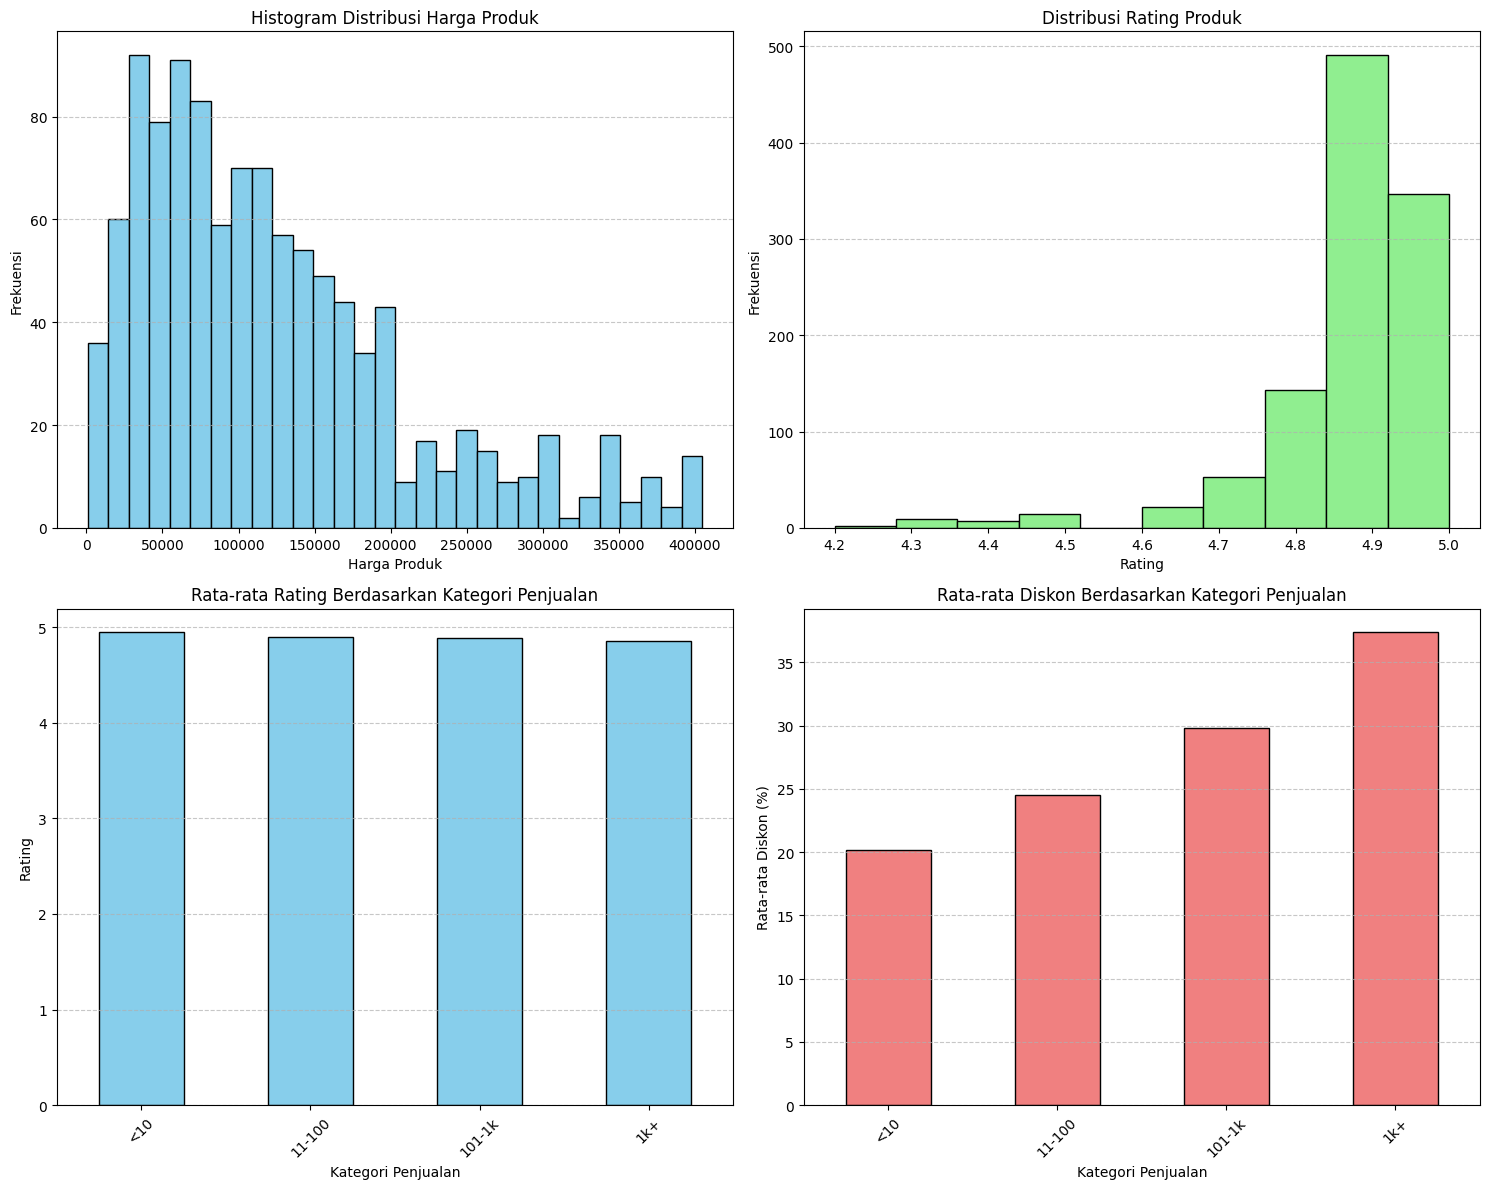

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Histogram price & rating
df['price'].plot.hist(bins=30, color='skyblue', edgecolor='black', ax=axes[0, 0], title='Histogram Distribusi Harga Produk')
axes[0, 0].set_xlabel('Harga Produk')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

df['rating'].plot.hist(bins=10, color='lightgreen', edgecolor='black', ax=axes[0, 1], title='Distribusi Rating Produk')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Frekuensi')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Bar charts
df.groupby('amountSold_category', observed=False)['rating'].mean().plot.bar(
    color='skyblue', edgecolor='black', ax=axes[1, 0], title='Rata-rata Rating Berdasarkan Kategori Penjualan')
axes[1, 0].set_xlabel('Kategori Penjualan')
axes[1, 0].set_ylabel('Rating')
axes[1, 0].set_xticklabels(labels, rotation=45)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

df.groupby('amountSold_category', observed=False)['discountPercentage'].mean().plot.bar(
    color='lightcoral', edgecolor='black', ax=axes[1, 1], title='Rata-rata Diskon Berdasarkan Kategori Penjualan')
axes[1, 1].set_xlabel('Kategori Penjualan')
axes[1, 1].set_ylabel('Rata-rata Diskon (%)')
axes[1, 1].set_xticklabels(labels, rotation=45)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [7]:
X = df[['discountPercentage', 'rating']]
y = df['amountSold_category']

model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

print(result.summary())

Optimization terminated successfully.
         Current function value: 1.246141
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
                              OrderedModel Results                             
Dep. Variable:     amountSold_category   Log-Likelihood:                -1355.8
Model:                    OrderedModel   AIC:                             2722.
Method:             Maximum Likelihood   BIC:                             2747.
Date:                 Thu, 09 Oct 2025                                         
Time:                         07:34:51                                         
No. Observations:                 1088                                         
Df Residuals:                     1083                                         
Df Model:                            2                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------

In [8]:
# 'price', 'discountPercentage'
X = df[['price', 'amountSold_category']].copy()
X['amountSold_category'] = X['amountSold_category'].cat.codes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

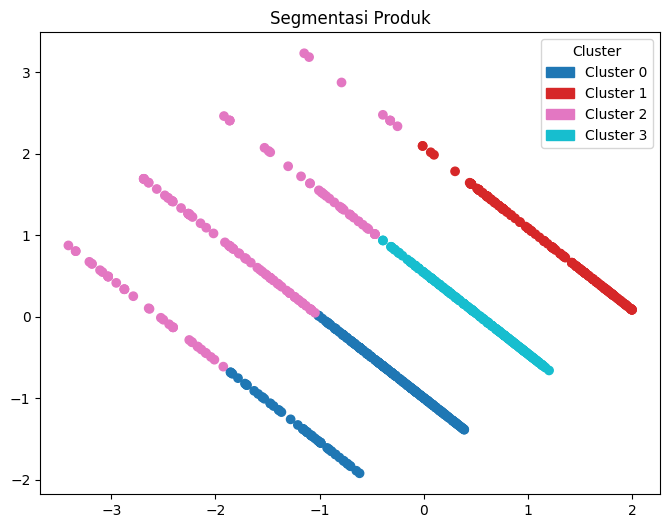

In [9]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:,0], pca_result[:,1], c=labels, cmap='tab10')
plt.title('Segmentasi Produk')

unique_labels = np.unique(labels)
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f'Cluster {i}') for i in unique_labels]
plt.legend(handles=handles, title='Cluster')
plt.show()

In [10]:
# Menghitung silhouette score untuk menilai kualitas klaster tanpa label sebenarnya
sil_score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.4596
